In [1]:
import utils
import matlab.engine
import dataset
import lstm_model
import importlib
import os

cfg = utils.Config(
    num_rx_antennas=1,
    num_tx_antennas=32,
    num_subcarriers=80,
    train_test_split=0.8,
    data_root="../data/dataset2",
    reduce_pca_overhead=False,
    epochs=10,
    compression_rate_dct=0.6,
    predictor_window_size = 5,
    total_bits=512,
    results_save_path="../results",
    compressor_type="kmeans",
    preprocessor_type="real_imag",
    trunc_lstm_pred=20
    # duplicate_data=1,
    # data_snr=-1
)


dataset.combine_time_series_paths(
    cfg.data_root,
    list(range(33)),
    2.5e9,
    "train_set.pickle"
)
dataset.combine_time_series_paths(
    cfg.data_root,
    list(range(34, 40)),
    2.5e9,
    "test_set.pickle"
)

train_set = dataset.dataset_from_path(os.path.join(cfg.data_root, "train_set.pickle"), cfg)
test_set = dataset.dataset_from_path(os.path.join(cfg.data_root, "test_set.pickle"), cfg)
matlab = matlab.engine.start_matlab()
# refModel = lstm_model.FullLSTMModel(cfg, matlab)
refModel = lstm_model.TruncatedLSTMModel(cfg, matlab)


Saving files to  ../data/dataset2/train_set.pickle
Number of samples (14320, 1, 32, 1, 80)
Saving files to  ../data/dataset2/test_set.pickle
Number of samples (2655, 1, 32, 1, 80)
This is the LSTM


In [2]:
refModel.fit(train_set)

Fitting the PCA
Fitting the LSTM
Epoch 1/10


/Users/dziper/opt/anaconda3/envs/csi/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


895/895 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0417
Epoch 2/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0370
Epoch 3/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0353
Epoch 4/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0330
Epoch 5/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0303
Epoch 6/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0276
Epoch 7/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0248
Epoch 8/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0226
Epoch 9/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0205
Epoch 10/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0192
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Training k-means clustering...
Considering bTot: 100
Considering bTot: 200
Considering bTot: 300
Considering bTot: 400
Considering bTot: 500


  0%|          | 0/12 [00:00<?, ?it/s]

In [3]:
# Downlink
compressed_error, X_test = refModel.process(test_set)

# Uplink
predicted_csis, ul_pred_zdl = refModel.decode(compressed_error, X_test)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predicted zdl: (2645, 500)
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predicted zdl: (2645, 500)
ul_pred_error: (2645, 500)


Assessing performance...
Plotting results...


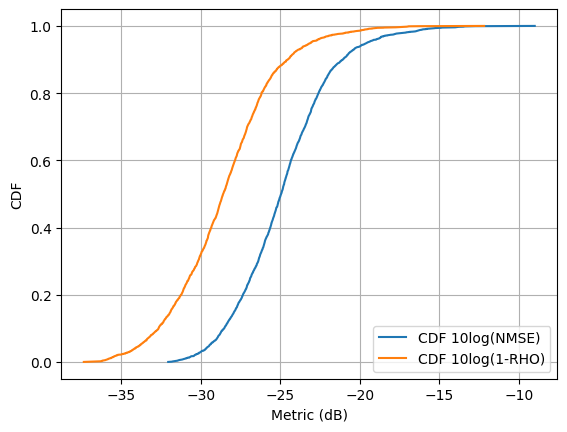

In [4]:
utils.reference_nmse_rho_test("lstm_with_linear", test_set.csi_samples[cfg.predictor_window_size:], predicted_csis, save_path=cfg.results_save_path, btot=cfg.total_bits)

In [12]:
# Check Windows are working

i = 0
print(test_set.csi_samples[i:i+5, 1, 0:3])
print(test_set.csi_windows[i, -5:, 1, 0:3])


[[ 0.705801  +0.75463873j  0.84435874+0.67535996j  0.96643853+0.549481j  ]
 [-0.39190415-0.1254128j  -0.5548773 +0.01302063j -0.67404807+0.18823142j]
 [-0.8066928 -0.11294912j -0.94277555+0.05165101j -1.0272592 +0.24942768j]
 [-0.54924756+0.94118845j -0.36871737+0.9699944j  -0.18635513+0.93960357j]
 [-0.50491065-0.16013099j -0.5244756 -0.19620246j -0.5534765 -0.22544478j]]
[[-8.0063143e-07+8.3136271e-08j -5.5626924e-07-1.3785609e-08j
  -3.3257334e-07-1.6913255e-07j]
 [ 5.9488536e-07-2.2053237e-06j  5.8191210e-07-2.2263846e-06j
   5.6197723e-07-2.2555962e-06j]
 [ 1.2543429e-06-2.4318415e-06j  1.1567962e-06-2.4696999e-06j
   1.0618014e-06-2.4959002e-06j]
 [-4.2394660e-07+1.2255572e-06j -7.2937371e-07+1.1615931e-06j
  -1.0727886e-06+1.2319172e-06j]
 [-2.1120718e-06+3.0095991e-06j -1.8403878e-06+3.0061501e-06j
  -1.6277386e-06+2.9363330e-06j]]


Text(0.5, 1.0, 'Full Prediction')

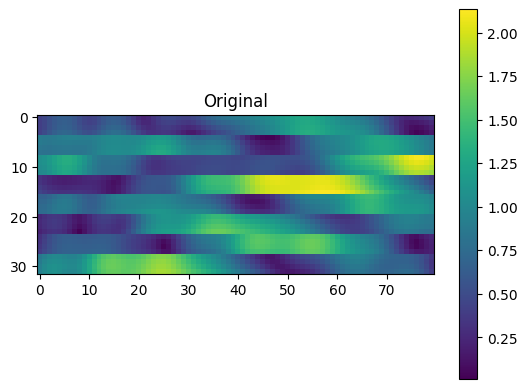

<Figure size 640x480 with 0 Axes>

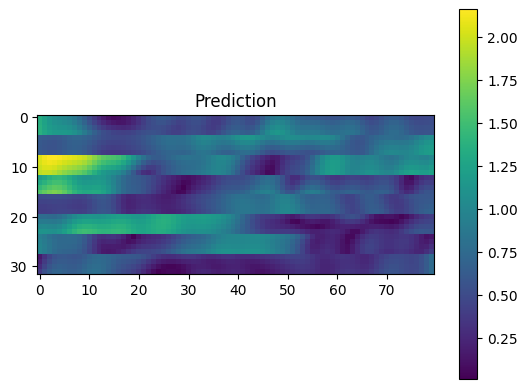

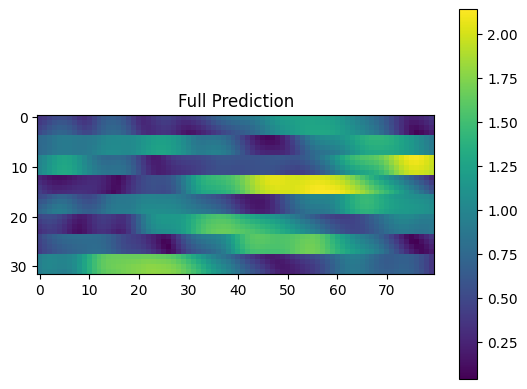

In [6]:
import matplotlib.pyplot as plt
import numpy as np

idx = 15

def plot_single_zdl(zdl, pca):
    plt.figure()
    zdl = np.expand_dims(zdl, axis=0)
    recovered = pca.decode(zdl)
    plt.imshow(np.squeeze(np.abs(recovered)))
    
plt.imshow(np.squeeze(np.abs(test_set.csi_samples[cfg.predictor_window_size + idx])))
plt.title("Original")

plt.colorbar()
plt.figure()
plot_single_zdl(ul_pred_zdl[idx], refModel.pca)
plt.colorbar()
plt.title("Prediction")

plt.figure()

plt.imshow(np.squeeze(np.abs(predicted_csis[idx])))
plt.colorbar()
plt.title("Full Prediction")



Text(0.5, 1.0, 'ZDL Trunc 16')

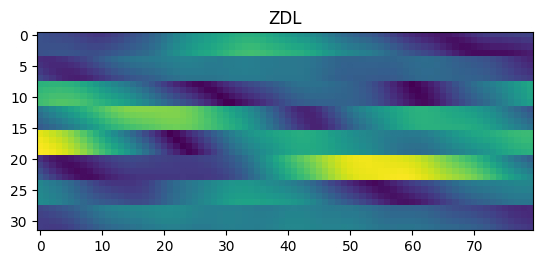

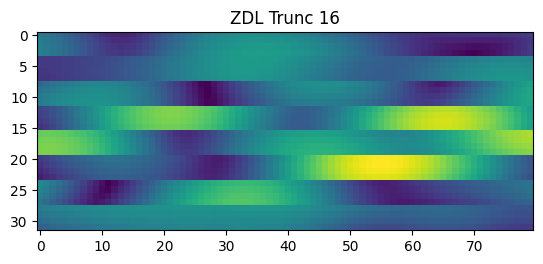

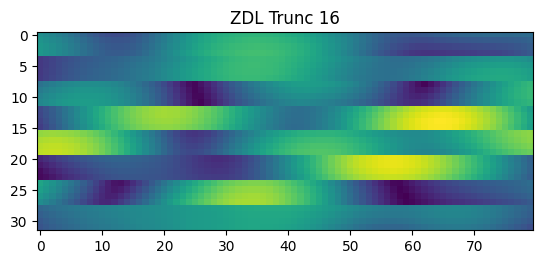

In [19]:

sample = test_set.csi_samples[idx : idx + 1]
zdl = refModel.pca.process(sample)
plot_single_zdl(zdl, refModel.pca)
plt.title("ZDL")


zdl_trunc = 16

sample = test_set.csi_samples[idx : idx + 1]
zdl = refModel.pca.process(sample)
zdl[0, zdl_trunc:] = 0
plot_single_zdl(zdl, refModel.pca)
plt.title(f"ZDL Trunc {zdl_trunc}")


## Pure DCT on Test Channels

In [30]:
from error_compression import reshape_tensor
from DCT_compression import DCTCompression
#load the dataset
# train_set, test_set = dataset.load_data(cfg)

cfg = utils.Config(
    num_rx_antennas=1,
    num_tx_antennas=32,
    num_subcarriers=80,
    train_test_split=0.8,
    data_root="../data/dataset1",
    reduce_pca_overhead=False,
    epochs=10,
    compression_rate_dct=0.997,
    # total_bits=  @Ibrahim change the bits here
    # duplicate_data=1,
    # data_snr=-1
)


csis = reshape_tensor(test_set.csi_samples , K=1)

compressor = DCTCompression(cfg, matlab)
compressor.fit(csis)
zdlcomp = compressor.process(csis)
predicted_csis = compressor.decode(zdlcomp)
predicted_csis = predicted_csis.reshape(test_set.csi_samples.shape)

DCT Compression: Preparing to compress to 7 coefficients


Assessing performance...
Plotting results...


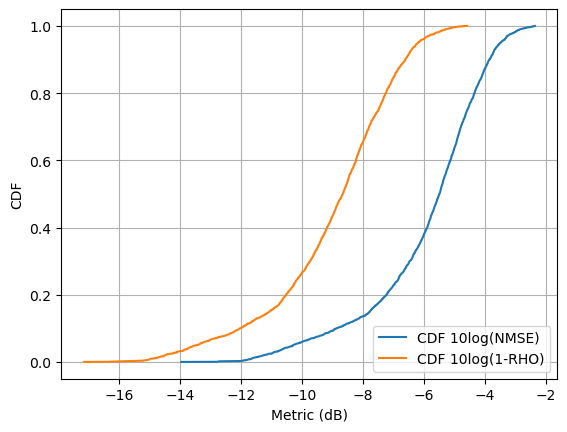

In [31]:
utils.reference_nmse_rho_test("lstm_plot", test_set.csi_samples, predicted_csis)

In [14]:
import os

cfg = utils.Config(
    num_rx_antennas=1,
    num_tx_antennas=32,
    num_subcarriers=80,
    train_test_split=0.8,
    data_root="../data/dataset2",
    reduce_pca_overhead=False,
    epochs=10,
    compression_rate_dct=0.6,
    predictor_window_size = 20,
    total_bits=512,
    results_save_path="../results",
    compressor_type="kmeans"
    # duplicate_data=1,
    # data_snr=-1
)


dataset.combine_time_series_paths(
    cfg.data_root,
    list(range(33)),
    2.5e9,
    "train_set.pickle"
)
dataset.combine_time_series_paths(
    cfg.data_root,
    list(range(34, 40)),
    2.5e9,
    "test_set.pickle"
)

train_set = dataset.dataset_from_path(os.path.join(cfg.data_root, "train_set.pickle"), cfg)
test_set = dataset.dataset_from_path(os.path.join(cfg.data_root, "test_set.pickle"), cfg)


Saving files to  ../data/dataset2/train_set.pickle
Number of samples (14320, 1, 32, 1, 80)
Saving files to  ../data/dataset2/test_set.pickle
Number of samples (2655, 1, 32, 1, 80)


In [16]:
i = 0
print(test_set.csi_samples[i:i+5, 1, 0:3])
print(test_set.csi_windows[i, -5:, 1, 0:3])



[[ 2.2982285e-06+2.4572539e-06j  2.7494002e-06+2.1991066e-06j
   3.1469162e-06+1.7892194e-06j]
 [-1.2606382e-06-4.0341541e-07j -1.7848740e-06+4.1883467e-08j
  -2.1682108e-06+6.0548410e-07j]
 [-2.6094713e-06-3.6536522e-07j -3.0496687e-06+1.6707951e-07j
  -3.3229546e-06+8.0684293e-07j]
 [-1.7838869e-06+3.0568615e-06j -1.1975476e-06+3.1504196e-06j
  -6.0525798e-07+3.0517140e-06j]
 [-1.2378445e-06-3.9257890e-07j -1.2858101e-06-4.8101208e-07j
  -1.3569091e-06-5.5270289e-07j]]
[[-8.0063143e-07+8.3136271e-08j -5.5626924e-07-1.3785609e-08j
  -3.3257334e-07-1.6913255e-07j]
 [ 5.9488536e-07-2.2053237e-06j  5.8191210e-07-2.2263846e-06j
   5.6197723e-07-2.2555962e-06j]
 [ 1.2543429e-06-2.4318415e-06j  1.1567962e-06-2.4696999e-06j
   1.0618014e-06-2.4959002e-06j]
 [-4.2394660e-07+1.2255572e-06j -7.2937371e-07+1.1615931e-06j
  -1.0727886e-06+1.2319172e-06j]
 [-2.1120718e-06+3.0095991e-06j -1.8403878e-06+3.0061501e-06j
  -1.6277386e-06+2.9363330e-06j]]


In [17]:
zdl_train = refModel.pca.process(train_set.csi_samples)                # N * zdl_len

X_train, y_train = refModel._preprocess(zdl_train, apply_existing=False)


In [20]:
m = 100
idx = -1
for i in range(30):
    x_ele = X_train[0, i, :3]
    y_ele = y_train[25, :3]
    diff = np.sum(np.abs(x_ele - y_ele))
    
    if diff < m:
        m = diff
        idx = i
        
print(f"{m}, {i}")

0.2046002596616745, 29


In [23]:
print(X_train[2, cfg.predictor_window_size-1, :3])
print(y_train[1, :3])


[-0.5160218  -0.12020815  0.48075524]
[-0.5160218  -0.12020815  0.48075524]
